# Bright Block Data Processing Notebook


## Functions used for checking + testing data

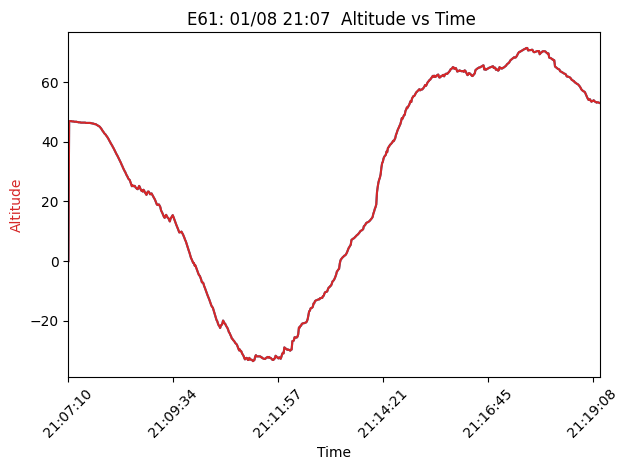

In [774]:
# Example usage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()
dataType1 = "Altitude" 
# dataType2 = "correctedPressurehPa" 

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(dataType1, color=color)
ax1.plot(df['TimeStampHMS'], df[dataType1], color=color)
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel(dataType1 , color = color)
ax1.plot(df['TimeStampHMS'], df[dataType1], color=color)

# ax1.plot(df['TimeStampHMS'], -df[dataType2] +df[dataType1] + df[dataType1][0], color=color)
ax1.tick_params(axis='y')

startTime = df["TimeStampHMS"][df.index.min()]
final_Index = np.size(df.TimeStampAdjusted)-1; 
end_time = df["TimeStampHMS"][final_Index]

# Rotate the date-time labels for better readability
plt.xticks(rotation=45)
count_ticks = 10 #FIXME something up with the number of datapoints
step_size = len(df['TimeStampHMS'])/count_ticks
ax1.set_xticks(np.arange(0, len(df['TimeStampHMS']),  step_size))
ax1.set_xlim(startTime, end_time)

plt.title(autoName + "  "+ dataType1 + " vs Time ")
fig.tight_layout()
plt.show()

In [1]:
import requests

def get_altitude(latitude, longitude):
    # Open Elevation API endpoint
    url = "https://api.open-elevation.com/api/v1/lookup"

    # Parameters for the API request
    params = {
        "locations": f"{latitude},{longitude}"
    }

    # Making the request to the API
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        # Extract the altitude from the response
        # The structure is {'results': [{'elevation': altitude, 'latitude': lat, 'longitude': lon}]}
        if data["results"]:
            altitude = data["results"][0]["elevation"]
            return altitude
        else:
            print("No elevation data found for the given coordinates.")
            return None
    else:
        print(f"Error fetching data: {response.status_code}")
        return None

# Example usage
# Replace with actual coordinates
    

def lookupAltitude(df):
# Define a lambda function that applies get_altitude to each row
    df['lookedUpAltitude'] = df.apply(lambda row: get_altitude(row['Latitude'], row['Longitude']), axis=1)
    return df
newDf = lookupAltitude(df)


NameError: name 'df' is not defined

In [778]:
import pandas as pd
import numpy as np

def correct_pressure(df, altitude_column):
    # Constants
    P0 = 1013.25  # Sea level standard atmospheric pressure in hPa
    L = 0.0065    # Standard temperature lapse rate in K/m
    T0 = 288.15   # Standard temperature at sea level in K
    g = 9.80665   # Acceleration due to gravity in m/s²
    M = 0.0289644 # Molar mass of Earth's air in kg/mol
    R = 8.3144598 # Universal gas constant in J/(mol·K)

    # Corrected Pressure Calculation
    df['correctedPressurehPa'] = P0 * (1 - (L * df[altitude_column]) / T0) ** (g * M / (R * L))

    return df

# Usage example
df = data
df = correct_pressure(df, 'Altitude')


In [2]:
%reset 
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from math import radians, cos, sin, sqrt, atan2

def change_time_zone(uncorrected_time_zone_list, TimeZoneAdjustHours, yearsAdjustment):
    corrected_time_zone_list = []

    for timestamp in uncorrected_time_zone_list:
        # Parse the timestamp into a datetime object
        dt = datetime.strptime(timestamp, '%H:%M:%S %d/%m/%Y')
        # print(dt)

        # Adjust the time zone
        adjusted_dt = dt + timedelta(hours=TimeZoneAdjustHours)
        
        # Adjust the year
        adjusted_dt = adjusted_dt.replace(year=adjusted_dt.year + yearsAdjustment)

        # Convert back to the string format and add to the list
        corrected_time_zone_list.append(adjusted_dt.strftime('%H:%M:%S %d/%m/%Y'))

    return corrected_time_zone_list

def count_row_duplicates(df):
    # Create a temporary DataFrame indicating duplicated rows
    temp_df = df.copy()
    temp_df['IsDuplicated'] = df.duplicated(keep=False)

    # Group by all columns (excluding the 'IsDuplicated' column) and count duplicates
    duplicate_counts = temp_df.groupby(list(df.columns))['IsDuplicated'].sum()

    return duplicate_counts.reset_index(name='DuplicationCount').sort_values(by='TimeStamp', ascending=True)

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance in kilometers between two points on the Earth."""
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def calculate_velocity(df, rolling_sample):
    # Ensure the DataFrame is sorted by time
    df['TimeStampAdjusted'] = pd.to_datetime(df['TimeStampAdjusted'], format='%H:%M:%S %d/%m/%Y')
    df = df.sort_values('TimeStampAdjusted')

    # Calculate the distance and time difference
    df['lat_shifted'] = df['Latitude'].shift()
    df['lon_shifted'] = df['Longitude'].shift()
    df['time_shifted'] = df['TimeStampAdjusted'].shift()

    df['dist'] = df.apply(lambda row: haversine(row['lat_shifted'], row['lon_shifted'], row['Latitude'], row['Longitude']) if pd.notnull(row['lat_shifted']) else 0, axis=1)
    df['time_diff'] = (df['TimeStampAdjusted'] - df['time_shifted']).dt.total_seconds() / 3600

    # Apply rolling sample
    df['rolling_dist'] = df['dist'].rolling(window=rolling_sample, min_periods=1).sum()
    df['rolling_time'] = df['time_diff'].rolling(window=rolling_sample, min_periods=1).sum()

    # Calculate velocity (km/h)
    df['velocity_km_h'] = df['rolling_dist'] / df['rolling_time']
    df['velocity_km_h'] = df['velocity_km_h'].replace([np.inf, -np.inf], 0)  # Handle division by zero
    df['velocity_m_h'] = df['velocity_km_h'] * 0.621371 
    return df.drop(['lat_shifted', 'lon_shifted', 'time_shifted', 'dist', 'time_diff', 'rolling_dist', 'rolling_time'], axis=1)

def makeLeaflet(df, dataType, autoName, autoThreshold: bool, highThreshold = 50, lowThreshold = 0):
    import folium
    from branca.colormap import LinearColormap
    from branca.element import Figure
    from folium import IFrame, Marker

    centralLatitude = df.Latitude.mean()
    centralLongitude = df.Longitude.mean()
    leftLongitude = df.Longitude.min()
    rightLongitude =  df.Longitude.max()
    longitudeSpan = rightLongitude - leftLongitude
    topLatitude = df.Latitude.max()
    bottomLatitude = df.Latitude.min()
    latitudeSpan = topLatitude - bottomLatitude

    if autoThreshold == True:
        highThreshold = df[dataType].max()
        lowThreshold = 0

    colors = ["green", "yellow", "red"]

    # Create a Folium map
    colormap = LinearColormap(colors, vmin=lowThreshold, vmax=highThreshold)
    m = folium.Map(location=[centralLatitude, centralLongitude],tiles="Cartodb Positron", zoom_start=14)
    colormap.caption = dataType 

    # Prepare data for the line
    line_data = [(row['Latitude'], row['Longitude']) for index, row in df.iterrows()]

    # Normalize data values and get colors
    normColorData = [colormap(min(max(row[dataType], lowThreshold), highThreshold)) for index, row in df.iterrows()]

    # Plot the line
    for i in range(len(line_data)-1):
        folium.PolyLine(line_data[i:i+2], color=normColorData[i], weight=5).add_to(m)
        
        
    markers = df[(df['ButtonPress'] != 0)].reset_index()
    for i in range(len(markers)):
        folium.CircleMarker(location=[markers.Latitude[i] , markers.Longitude[i]], color = 'black', icon_color= 'red', radius=3, fill=True).add_to(m)

    # Add the colormap to the map
    colormap.add_to(m)

    # Create a Figure and add the map to it (for better control)
    fig = Figure(width=800, height=500)
    fig.add_child(m)

    # Add the title HTML to the Folium map
    Marker(location=[centralLatitude + latitudeSpan/2, centralLongitude - longitudeSpan/3], icon=folium.DivIcon(html=f"""
                <div style="
                    background-color: white; 
                    border: 1px solid black;
                    padding: 10px;
                    font-family: arial; 
                    color: black;
                    text-align: center;
                    white-space: nowrap; /* Prevents text wrapping */
                    width: auto; /* Adjust width as needed */
                    display: inline-block; /* Ensure background covers text */
                    ">
                    {autoName}
                </div>
                """)
    ).add_to(m)

    # Display the map
    return m

## Big picture tasks for this dataset

Standardize Collection Graphs to capture the following:
 - Every graph needs to be automatically saved with Event #, Timestamp, should log which data collection/hardware setup I am using for different "data runs" (link that here maybe) 
 1. PM2.5 vs spacial Location, flagging any events I thought were high emmissions [done see below :)]
 2. Pressure vs time Graph [done see below :)]
 3. Presssure vs speed graph [inProgress]
 4. Cost function comparaitive to Purple air? [tabled]


### Arising Bugs
 1. What the fuck is up with this duplication???
 Behavior : Seeing data points which seem to be repeated up to 5X per data point [logginging severity in run metrics]. It looks like I may be logging too quick for the sensor to appropriatly pick up on it so that I am logging at a rate above 1 Hz, BUT my timestamp only goes to 1 HZ so I am additionallly seeing new events "filed" under the same index. 

 
        a. Do I need to monitor battery? (Voltage dividor with  high enough resistance to not worry about power draw)
        b. Do I need to also have a seperate timer running on the device as to not pull only from the GPS

2. GPS Data does not perfectly map onto page (related to battery life?)

        a.  Mapbox has a plugin for this, look into this in more detail
        b. Check into other GPS modules (?) Plan to use phone longterm?
 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

FileNo = '61' 
file_path = 'RawData/Event' + FileNo + '.txt'
data = pd.read_csv(file_path, header=0)


#Screening for GPS Data 
data = data[(data['Latitude'] != 0) | (data['Longitude'] != 0)]
data = count_row_duplicates(data)
averageDuplication = np.mean(data.DuplicationCount)

# Adjust timestamp
TimeZoneAdjust = -8
yearsAdjustment = 2000

# need to change this in order to process the funky timezones as they come up
data["TimeStampAdjusted"] = change_time_zone(data.TimeStamp, TimeZoneAdjust, yearsAdjustment) 
data["TimeStampHMS"] = data["TimeStampAdjusted"].str[0:8]

startTime = data["TimeStampAdjusted"][data.index.min()]

formatted_date = startTime[12:15] + startTime[9:11] + " " +startTime[0:5];  # '09:22:26 04/12/0023'
autoName = 'E' + FileNo + ": " +  formatted_date   
Pressure_STD = np.std(data["PressurehPa" ])
Pressure_Mean = np.mean(data["PressurehPa" ])

initial_pressure = data["PressurehPa"][0]
pressureDeltaNormalized = sum((data["PressurehPa"] - initial_pressure)**2)/len(data["PressurehPa"])

rollingAveraging = 20
data = calculate_velocity(data, rollingAveraging)
data = data.replace(np.nan, 0)

dataType1 = "velocity_m_h" 
dataType2 = "PressurehPa" 
correlationP = np.corrcoef([data[dataType1], data[dataType2]])
bestFit = np.polyfit(data[dataType1], data[dataType2],1)
bestFit0 = bestFit[1] + data[dataType1].min() * bestFit[0]
bestFitEnd = bestFit[1] + data[dataType1].max() * bestFit[0]

print("Processing:", autoName)
print("Num Unique Data Points: " + '{:d}'.format(len(data["PressurehPa"])))

print("Average Pressure: " + '{:.2f}'.format(Pressure_Mean))
print("Average Speed: " + '{:.2f}'.format(data.velocity_m_h.mean()))
print("Correlation Coeff: " + '{:.2f}'.format(correlationP[0,1]))
print("Pressure Error Term: " + '{:.2f}'.format(pressureDeltaNormalized))
print("Average Duplication: " + '{:.2f}'.format(averageDuplication))

Processing: E61: 01/08 21:07
Num Unique Data Points: 1437
Average Pressure: 1025.88
Average Speed: 11.04
Correlation Coeff: 0.04
Pressure Error Term: 3.60
Average Duplication: 3.20


## [1] Plotting the physical PM2.5 Map 


In [4]:
mapObject = makeLeaflet(data,"PM25",autoName, True)
mapObject

In [5]:
mapObject = makeLeaflet(data,"vocIndex",autoName, True)
mapObject

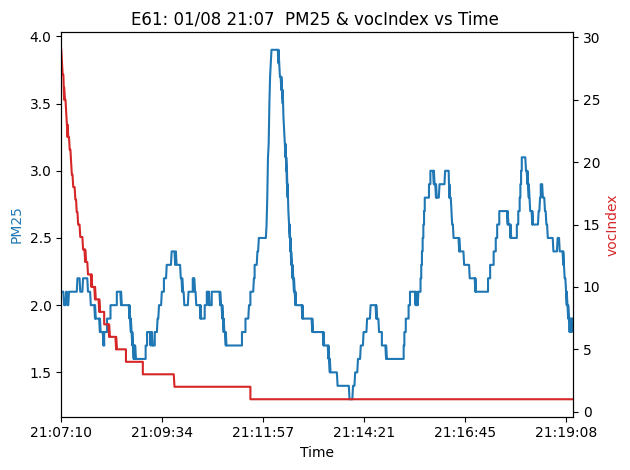

In [749]:
# Example usage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()
dataType1 = "PM25" 
dataType2 = "vocIndex" 

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(dataType1, color=color)
ax1.plot(data['TimeStampHMS'], data[dataType1], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel(dataType2, color = color)
ax2.plot(data['TimeStampHMS'], data[dataType2], color=color)
ax2.tick_params(axis='y')

startTime = data["TimeStampHMS"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampHMS"][final_Index]

# Rotate the date-time labels for better readability
plt.xticks(rotation=45)
count_ticks = 10 #FIXME something up with the number of datapoints
step_size = len(data['TimeStampHMS'])/count_ticks
ax1.set_xticks(np.arange(0, len(data['TimeStampHMS']),  step_size))
ax1.set_xlim(startTime, end_time)

plt.title(autoName + "  "+ dataType1 + " & " + dataType2 + " vs Time ")
fig.tight_layout()
plt.show()


## [2] Pressure vs Time Graph

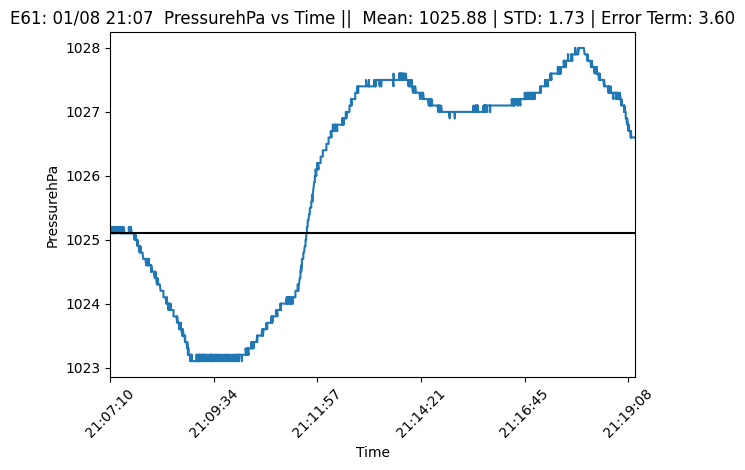

In [750]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()
dataType = "PressurehPa" 
initial_pressure = data[dataType][0]
pressureDelta = sum((data[dataType] - initial_pressure)**2)
pressureDeltaNormalized = pressureDelta/len(data[dataType])

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(dataType)
ax1.plot(data['TimeStampHMS'], data[dataType], color=color)
ax1.tick_params(axis='y')

startTime = data["TimeStampHMS"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampHMS"][final_Index]
initial_pressure = data[dataType][0]
ax1.plot([startTime, end_time], [initial_pressure,initial_pressure] , color='black')

# Rotate the date-time labels for better readability
plt.xticks(rotation=45)
count_ticks = 10 #FIXME something up with the number of datapoints
step_size = len(data['TimeStampHMS'])/count_ticks
ax1.set_xticks(np.arange(0, len(data['TimeStampHMS']),  step_size))
ax1.set_xlim(startTime, end_time)

plt.title(autoName + "  "+ dataType + " vs Time ||  Mean: " + '{:.2f}'.format(Pressure_Mean) + " | STD: " + '{:.2f}'.format(Pressure_STD) + " | Error Term: " + '{:.2f}'.format(pressureDeltaNormalized))
fig.tight_layout()
plt.show()


##  3. Presssure vs speed graph

### Leaflet 

In [751]:
mapObject = makeLeaflet(data,"velocity_m_h",autoName, True)
mapObject

### Plotting Speed and Pressure vs Time

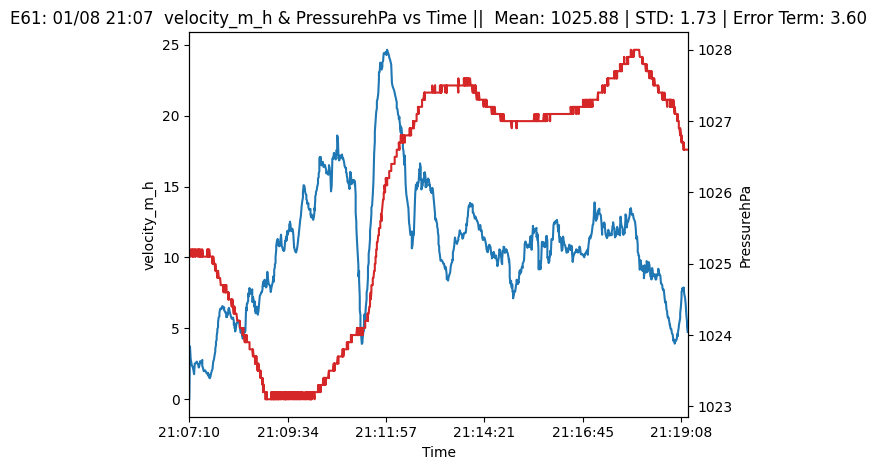

In [752]:
# Example usage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()
dataType1 = "velocity_m_h" 
dataType2 = "PressurehPa" 

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(dataType1)
ax1.plot(data['TimeStampHMS'], data[dataType1], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel(dataType2)
ax2.plot(data['TimeStampHMS'], data[dataType2], color=color)
ax2.tick_params(axis='y')

startTime = data["TimeStampHMS"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampHMS"][final_Index]
pressureDelta = sum((data[dataType] - initial_pressure)**2)

# Rotate the date-time labels for better readability
plt.xticks(rotation=45)
count_ticks = 10 #FIXME something up with the number of datapoints
step_size = len(data['TimeStampHMS'])/count_ticks
ax1.set_xticks(np.arange(0, len(data['TimeStampHMS']),  step_size))
ax1.set_xlim(startTime, end_time)

plt.title(autoName + "  "+ dataType1 + " & " + dataType2 + " vs Time ||  Mean: " + '{:.2f}'.format(Pressure_Mean) + " | STD: " + '{:.2f}'.format(Pressure_STD) + " | Error Term: " + '{:.2f}'.format(pressureDeltaNormalized))
fig.tight_layout()
plt.show()


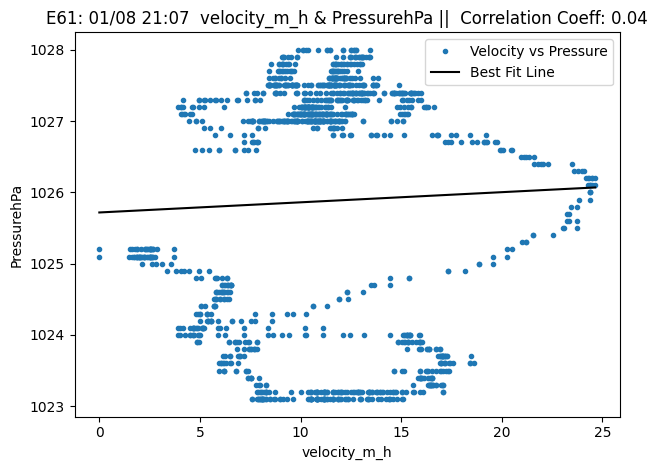

In [753]:
# Example usage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()
dataType1 = "velocity_m_h" 
dataType2 = "PressurehPa" 

# correlationP = np.corrcoef([data[dataType1], data[dataType2]])
# bestFit = np.polyfit(data[dataType1], data[dataType2],1)
# bestFit0 = bestFit[1] + data[dataType1].min() * bestFit[0]
# bestFitEnd = bestFit[1] + data[dataType1].max() * bestFit[0]

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel(dataType1)
ax1.set_ylabel(dataType2)
ax1.plot( data[dataType1], data[dataType2], '.',color=color, label = "Velocity vs Pressure")

ax1.plot( [data[dataType1].min(), data[dataType1].max()], [bestFit0, bestFitEnd],color='black', label ="Best Fit Line")

ax1.tick_params(axis='y')
ax1.legend()
plt.title(autoName + "  "+ dataType1 + " & " + dataType2 + " ||  Correlation Coeff: " + '{:.2f}'.format(correlationP[1,0]))
fig.tight_layout()
plt.show()


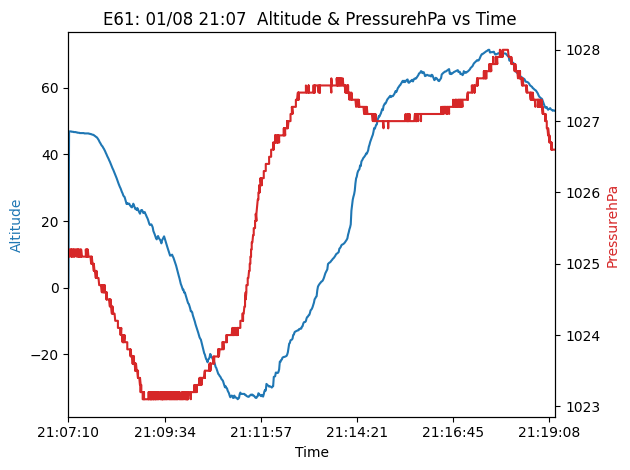

In [754]:
# Example usage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()
dataType1 = "Altitude" 
dataType2 = "PressurehPa" 

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(dataType1, color=color)
ax1.plot(data['TimeStampHMS'], data[dataType1], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel(dataType2, color = color)
ax2.plot(data['TimeStampHMS'], data[dataType2], color=color)
ax2.tick_params(axis='y')

startTime = data["TimeStampHMS"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampHMS"][final_Index]

# Rotate the date-time labels for better readability
plt.xticks(rotation=45)
count_ticks = 10 #FIXME something up with the number of datapoints
step_size = len(data['TimeStampHMS'])/count_ticks
ax1.set_xticks(np.arange(0, len(data['TimeStampHMS']),  step_size))
ax1.set_xlim(startTime, end_time)

plt.title(autoName + "  "+ dataType1 + " & " + dataType2 + " vs Time ")
fig.tight_layout()
plt.show()

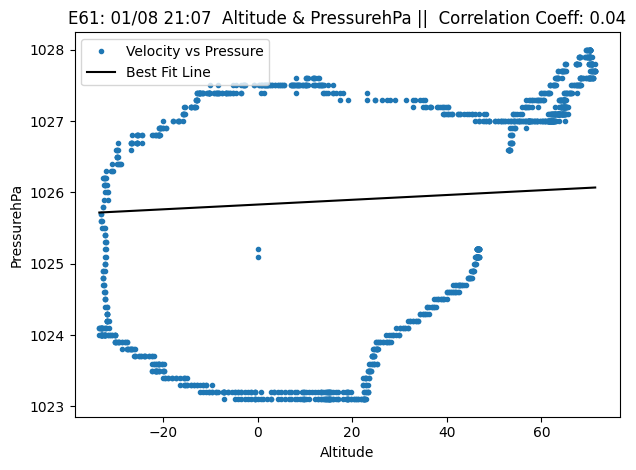

In [755]:
# Example usage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()
dataType1 = "Altitude" 
dataType2 = "PressurehPa" 

# correlationP = np.corrcoef([data[dataType1], data[dataType2]])
# bestFit = np.polyfit(data[dataType1], data[dataType2],1)
# bestFit0 = bestFit[1] + data[dataType1].min() * bestFit[0]
# bestFitEnd = bestFit[1] + data[dataType1].max() * bestFit[0]

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel(dataType1)
ax1.set_ylabel(dataType2)
ax1.plot( data[dataType1], data[dataType2], '.',color=color, label = "Velocity vs Pressure")

ax1.plot( [data[dataType1].min(), data[dataType1].max()], [bestFit0, bestFitEnd],color='black', label ="Best Fit Line")

ax1.tick_params(axis='y')
ax1.legend()
plt.title(autoName + "  "+ dataType1 + " & " + dataType2 + " ||  Correlation Coeff: " + '{:.2f}'.format(correlationP[1,0]))
fig.tight_layout()
plt.show()

## [Other] Duplication Debug Code 

Two Plots showing Duplication in the dataset

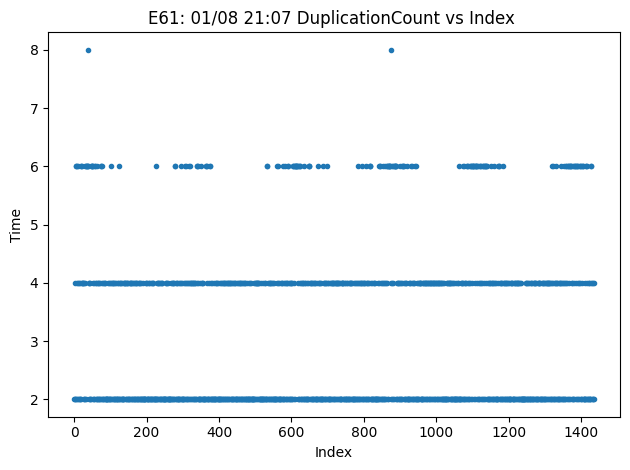

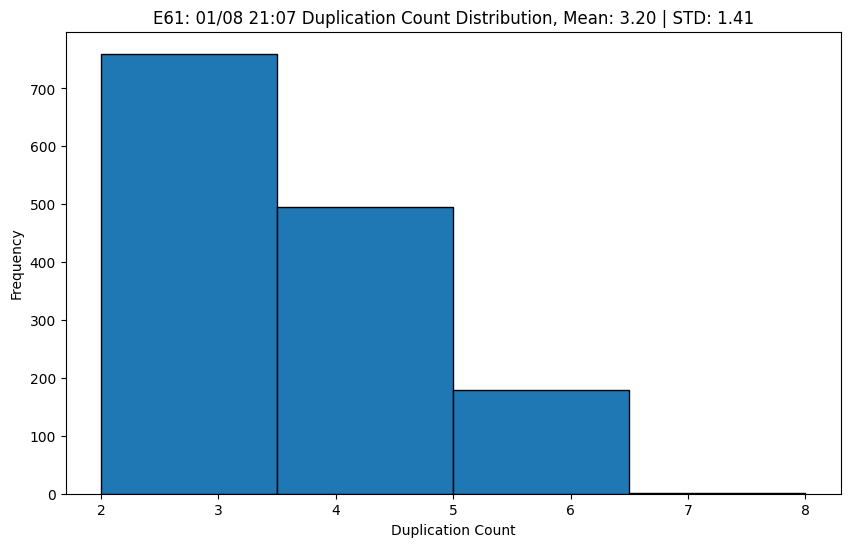

In [756]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Time')
ax1.plot(data['DuplicationCount'],'.' , color=color)
ax1.tick_params(axis='y')

startTime = data["TimeStampAdjusted"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampAdjusted"][final_Index]

count_ticks = 10
plt.title(autoName + " DuplicationCount vs Index ")

# Show the plot
fig.tight_layout()
plt.show()

# Create a new figure for the histogram
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(data['DuplicationCount'], bins=4, color='tab:blue', edgecolor='black')

Duplication_STD = np.std(data['DuplicationCount'])
Duplication_Mean = np.mean(data['DuplicationCount'])

# Set the title and labels
plt.title(autoName + " Duplication Count Distribution, Mean: " + '{:.2f}'.format(Duplication_Mean) + " | STD: " + '{:.2f}'.format(Duplication_STD) )
plt.xlabel('Duplication Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()
